# Serological Shields

Here, we use an age-structured epidemiological model to investigate how age-structured decision making may influence disease dynamics. The model incorporates 10 age classes (0-9 years old, 10-19 years old, ... 80-90 years old, 90+ years old); and 9 epidemiological states. The population who have not encountered the disease can be in a susceptible ($S$) class where there is the potential of being infected. Upon being exposed ($E$), the disease progresses either asymptomatically ($I_{asym}$) or symptomatically ($I_{sym}$). Of those who display symptoms, some will recover alone, but others will require sub-critical ($I_{h,sub}$) or critical (ICU beds required) ($I_{h,crit}$) hospital care. Of those in critical condition some will be killed by the disease ($D$). Those who do not die from the disease recover ($R$) with immunity to the disease. If recovered individuals can be identified they can take up key positions requiring face-to-face interactions, without further spreading the disease. They will not be able to catch the disease from infected individuals, and will not be able to transmit the disease to the susceptible population. Therefore, it is beneficial for people to interact with those who are serologically shown to have recovered from covid-19 and who are no longer shedding viruses. In this way identified recovered individuals can act as "serological shields" through becoming preferential contacts for those who have not been tested.

## Load package dependencies

In [1]:
using DrWatson
quickactivate(@__DIR__)

using DifferentialEquations
using Parameters
using Plots

┌ Info: Recompiling stale cache file /home/jvelez/.julia/compiled/v1.0/DrWatson/Vn5dT.ji for DrWatson [634d3b9d-ee7a-5ddf-bec9-22491ea816e1]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/jvelez/.julia/compiled/v1.0/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/jvelez/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


## Load source files

In [2]:
src_folder = srcdir("shield_immunity")
src_files = ["PopulationDemography.jl", "SerologicalShields.jl", "Utils.jl"]
for src_file=src_files include(joinpath(src_folder, src_file)) end

## Model

### Scheme

Consider a population of susceptible $S$, exposed $E$, infectious asymptomatic $I_{asym}$, infectious symptomatic $I_{sym}$, and recovered $R$ who are free to move, without restrictions in a ‘business as usual’ scenario. A subset of symptomatic cases will require hospital care, which we further divide into subacute $I_{h,sub}$, and critical/acute (i.e., requiring ICU intervention) $I_{h,crit}$ cases. Vital dynamics (births and other causes of death) are ignored for simplicity. The model is visually represented below:

### Mathemathical definition

The system of nonlinear differential equations governing this age-structured epidemiological model are shown below:

\begin{align}
\frac{dS(a)}{dt} & =  -\overset{new\ cases\ from\ symptomatic\ contact}{\overbrace{\frac{\beta_S S(a) I_{sym,Tot}}{N_{Tot} + \alpha R_{Shields}} }}  - \overset{new\ cases\ from\ asymptomatic\ contact}{\overbrace{\frac{\beta_A S(a) I_{asym,Tot}}{N_{Tot} + \alpha R_{Shields}} }}  \\
\frac{dE(a)}{dt} & =  \overset{new\ cases\ from\ symptomatic\ contact}{\overbrace{ \frac{\beta_S S(a) I_{sym,Tot}}{N_{Tot} + \alpha R_{Shields}} }} + \overset{new\ cases\ from\ asymptomatic\ contact}{\overbrace{\frac{\beta_A S(a) I_{asym,Tot}}{N_{Tot} + \alpha R_{Shields}} }}  - \overset{onset\ of\ disease}{\overbrace{\gamma_E E(a)}} \\
\frac{dI_{asym}(a)}{dt} & =  \overset{asymptomatic\ onset}{\overbrace{p(a)\gamma_E E(a)}} - \overset{recovery}{\overbrace{\gamma_A I_{asym}(a)}} \\
\frac{dI_{sym}(a)}{dt} & =  \overset{symptomatic\ onset}{\overbrace{(1-p(a))\gamma_E E(a)}} - \overset{transfer\ from\ I_{sym}}{\overbrace{\gamma_S I_{sym}(a)}} \\
\frac{dI_{h,sub}(a)}{dt} & =  \overset{subcritical\ cases}{\overbrace{h(a)(1-\xi(a)) \gamma_S I_{sym}(a)}} - \overset{transfer\ from\ I_{h,sub}}{\overbrace{\gamma_h I_{h,sub}(a)}} \\
\frac{dI_{h,crit}(a)}{dt} & =  \overset{critical\ (ICU)\ cases}{\overbrace{h(a)\xi(a) \gamma_S I_{sym}(a)}} - \overset{transfer\ from\ I_{h,crit}}{\overbrace{\gamma_h I_{h,crit}(a)}} \\
\frac{dR(a)}{dt} & =  \overset{recovery\ from\ I_{asym}}{\overbrace{\gamma_A I_{asym}(a)}} - \overset{recovery\ from\ I_{sym}}{\overbrace{(1-h(a))\gamma_S I_{sym}(a)}} - \overset{recovery\ from\ I_{h,sub}}{\overbrace{\gamma_h I_{h,sub}(a)}} - \overset{recovery\ from\ I_{h,crit}}{\overbrace{(1-\mu)\gamma_h I_{h,crit}(a)}} \\
\frac{dD(a)}{dt} & = \overset{mortality}{\overbrace{\mu \gamma_h I_{h,crit}(a)}}
\end{align}

where $I_{sym,Tot}$ are the total number (across all age classes) of sympomatic infectious individuals, $I_{asym,Tot}$ are the total number of asymptomatic infectious individuals, $N_{Tot}$ is the total number of alive individuals (not in the $D$ state), and $R_{Shields}$ are the number of recovered individuals who could serve as serological shields.

>**Note:**  
The serological states model has $11$ parameters: the tramission rate from symptomatic infectious individuals $\beta_S$, the tramission rate from asymptomatic infectious individuals $\beta_A$, the mean exposed period $\frac{1}{\gamma_E}$, the mean asymptomatic infected period $\frac{1}{\gamma_A}$, the mean symptomatic infected period $\frac{1}{\gamma_S}$, $p$ the proportion of cases that result in asymptomatic infection, $h$ the proportion of cases with symptoms needing a hospital visit, $\xi$ the proportion of hospitilised cases that require critical ICU care, the mean period of hospitalisation $\frac{1}{\gamma_h}$, $\mu$ the proportion of critical cases that die from the disease, and $\alpha$ the level of serological shielding.  $h$ and $\xi$ are age-structured parameters.

## Model dynamics

### Population

Here, we define a population of 10,000,000 people with an age structure similar to that of the UK and the US. Let us contain the population demography in an object.

In [3]:
pop = PopulationDemography(class_structure=[0.12,0.14,0.14,0.13,0.13,0.13,0.10,0.06,0.04,0.01], size=1e7, n_states=8);

### Parameters

We model dynamics looking at a `high` and `low` level of transmission, and with three levels of serological shielding - either none, 2:1, 20:1, 50:1, or 100:1.

In [4]:
β_A = 0.4 # Asymptomatic transmission (days⁻¹).
β_S = 0.8 # Symptomatic transmission (days⁻¹).
γ_e = 1/4 # Inverse mean exposed period (days⁻¹).
γ_a = [1/4, 1/6] # Inverse mean asymptomatic period (days⁻¹) (low, high).
γ_s = [1/4, 1/6] # Inverse mean symptomatic period (days⁻¹) (low, high).
γ_h = 1/10 # Inverse mean hospitalised period (days⁻¹).
p = [0.95, 0.95,0.9,0.8,0.7,0.6,0.4,0.2,0.2,0.2] # Fraction of cases that are asymptomatic.
h = [0.1, 0.3, 1.2, 3.2, 4.9, 10.2, 16.6, 24.3, 27.3, 27.3]./100 # Fraction of cases that require a hospital visit (by age class).
ξ = [5, 5, 5, 5, 6.3, 12.2, 27.4, 43.2, 70.9, 70.9]./100 # Fraction of hospitalised cases that become critical and require critical care (by age class).
μ = 0.5.*ones(n_classes(pop)) # Mortality fraction.
αs = [0.0, 2.0, 20.0, 50.0, 100.0] # Levels of serological shielding.
serological = 3:6 # Classes with serological potential.

# Put the parameters in a vector.
parameters = [pop, β_A, β_S, p, γ_e, γ_a, γ_s, γ_h, h, ξ, μ, αs, serological];

### Initial conditions

An initial outbreak is seeded in this population given one exposed individual in the 20-29 age class.

In [5]:
u0 = zeros(n_variables(pop)) # Vector of initial states.
u0[idxs_per_state(pop)[1]] = pop.class_structure .* pop.size; # Put everything in S.
u0[3]-= 1 # Remove infectet from S ages 20-29.
u0[13] = 1 # Assign E cases ages 20-29.
u0 /= pop.size; # Renormalise.

### Run simulations

The simulation is run forward until 10,000 people have been exposed to the virus (i.e. 10,000 people are no longer in the susceptible states) - we use this time point (which we denote time 0 in our simulations) as the time at which intervention policies might be applied. At this point, once 10,000 people have already been exposed we simulate the dynamics forward either with, or without the interventions.

In [6]:
tspan = (0.0, 300.0)
begin_intervention_at = 1e4
simulations = run_simulations(u0, tspan, parameters, begin_intervention_at);

### Visualization

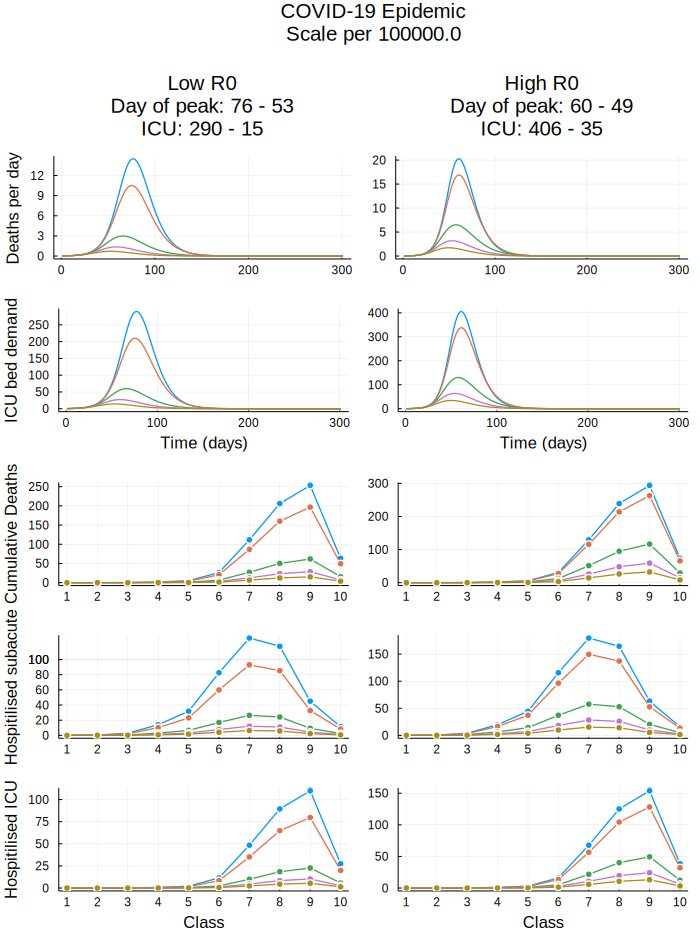

In [7]:
figure = plot_dynamics(simulations; scaling=1e5, size=(700,950), lw=1.3)
savefig(figure, plotsdir(basename(src_folder), "covid_epidemic_US-UK.jpg"))
figure